In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv("Country-data.csv")

# Exploritory Data Analysis

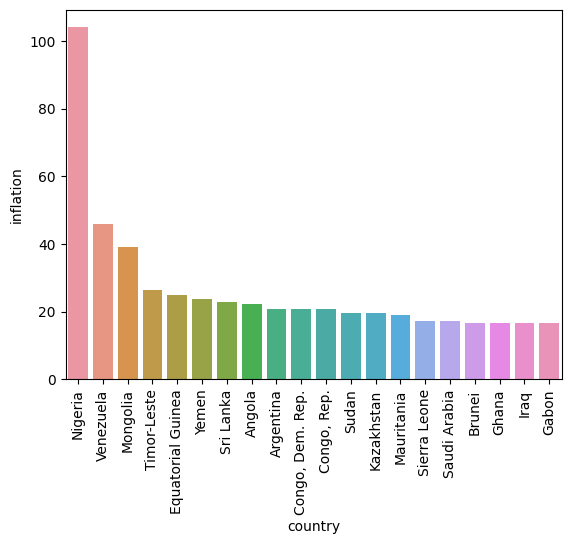

In [4]:
df_sorted_by_inflation = df.sort_values(by="inflation", ascending=False)
sns.barplot(df_sorted_by_inflation[:20], x="country", y="inflation")
plt.xticks(rotation=90)
plt.show()

<Axes: xlabel='exports', ylabel='imports'>

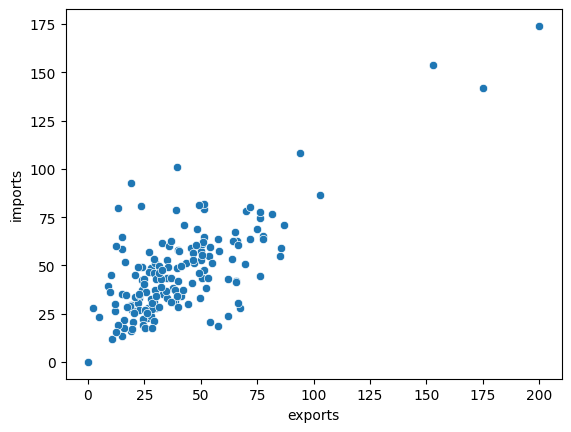

In [5]:
sns.scatterplot(df, x="exports", y="imports")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


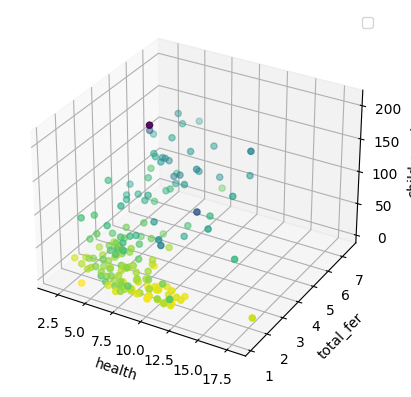

In [6]:
from mpl_toolkits import mplot3d

ax = plt.axes(projection="3d")
ax.scatter(df["health"], df["total_fer"], df["child_mort"], c=df["life_expec"], )
ax.set_xlabel("health")
ax.set_ylabel("total_fer")
ax.set_zlabel("child_mort")
plt.legend()

plt.show()

# Preprocessing

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [8]:
class RemoveCountryName(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.drop(columns=["country"])
        return X

In [9]:
class AddPopulation(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        country_population = pd.read_csv("country_population.csv")["pop"]
        country_population = country_population.apply(lambda x: x.split(" ")[0].replace(",", "."))
        X["pop"] = country_population.astype(float)
        return X

In [10]:
class ImputePopulation(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        imputer = SimpleImputer(strategy="mean", missing_values=-1)
        X[["pop"]] = imputer.fit_transform(X[["pop"]])
        return X

In [11]:
pipe = Pipeline([
    ("RemoveCountryName", RemoveCountryName()),
    ("AddPopulation", AddPopulation()),
    ("ImputePopulation", ImputePopulation())
])
trans_df = pipe.fit_transform(df)

In [12]:
from sklearn.preprocessing import MinMaxScaler
escaler = MinMaxScaler()
scaled_trans_df = escaler.fit_transform(trans_df)

# Model tuning

In [13]:
from sklearn.cluster import KMeans, MiniBatchKMeans, SpectralClustering, AgglomerativeClustering
n_clusters = 3

In [14]:
k_means = KMeans(n_clusters=n_clusters, random_state=42)
k_means_cluster = k_means.fit_predict(scaled_trans_df)

/home/amin/anaconda3/envs/countryclustering/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [15]:
mini_batch_kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
mini_batch_kmeans_cluster = mini_batch_kmeans.fit_predict(scaled_trans_df)

/home/amin/anaconda3/envs/countryclustering/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [16]:
spectralclustering = SpectralClustering(n_clusters=n_clusters)
spectralclustering_cluster = spectralclustering.fit_predict(scaled_trans_df)

In [17]:
agglomerativeclustering = AgglomerativeClustering(n_clusters=n_clusters)
agglomerativeclustering_cluster = agglomerativeclustering.fit_predict(scaled_trans_df)

In [18]:
class changeColumnNames(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.replace({"country": {
            "Bahamas":  "The Bahamas",
            "Central African Republic": "The Central African Republic",
            "Comoros": "The Comoros",
            "Congo, Dem. Rep.": "The Democratic Republic Of The Congo",
            "Congo, Rep.": "The Republic Of The Congo",
            "Cote d'Ivoire": "Ivory Coast",
            "Czech Republic": "The Czech Republic",
            "Dominican Republic": "The Dominican Republic",
            "Gambia": "The Gambia",
            "Kyrgyz Republic": "Kyrgyzstan",
            "Lao": "Laos",
            "Macedonia, FYR": "North Macedonia",
            "Maldives": "The Maldives",
            "Micronesia, Fed. Sts.": "The Federated States Of Micronesia",
            "Netherlands": "The Netherlands",
            "Philippines": "The Philippines",
            "Slovak Republic": "Slovakia",
            "St. Vincent and the Grenadines": "Saint Vincent And The Grenadines",
            "Timor-Leste": "East Timor",
            "United Arab Emirates": "The United Arab Emirates",
            "United Kingdom": "The United Kingdom",
            "United States": "The United States"
            
        }}, inplace=True)
        return X

In [19]:
df = changeColumnNames().fit_transform(df)

In [21]:
results = pd.DataFrame({
    "k_means": k_means_cluster,
    "mini_batch_kmeans": mini_batch_kmeans_cluster,
    "spectralclustering": spectralclustering_cluster,
    "agglomerativeclustering": agglomerativeclustering_cluster,
    "country": df["country"]
})

In [22]:
import sqlite3

connection = sqlite3.connect("country_clustering.db")
connection.text_factory = lambda x: str(x, 'utf-8')
c = connection.cursor()

c.execute(
    
    """
        CREATE TABLE IF NOT EXISTS country_clusters(
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        k_means CHAR NOT NULL,
        mini_batch_kmeans CHAR NOT NULL,
        spectralclustering CHAR NOT NULL,
        agglomerativeclustering CHAR NOT NULL,
        country VARCHAR(255) NOT NULL
        );
    """
)

connection.commit()

In [23]:
results.to_sql("country_clusters", con=connection, if_exists="append", index=False)

167

# Model evaluation

In [21]:
import mplcursors
%matplotlib ipympl

In [22]:
Xx = scaled_trans_df.T[1]
Xy = scaled_trans_df.T[3]

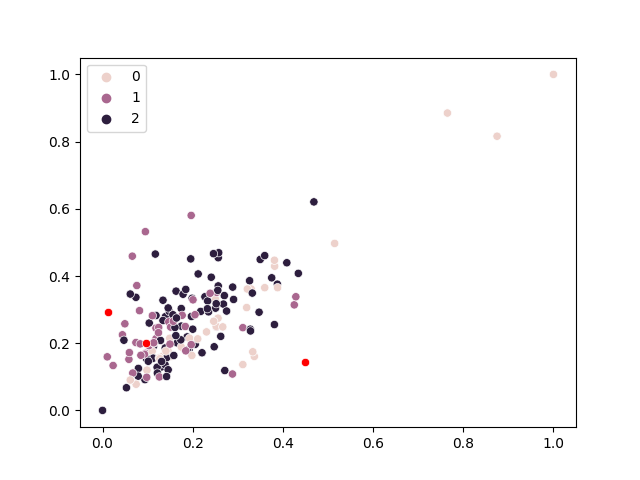

In [23]:
clusters = results["k_means"]
cluster_center = k_means.cluster_centers_
sns.scatterplot(x=Xx, y=Xy, hue=clusters)
sns.scatterplot(x=cluster_center[:, 0], y=cluster_center[:, 1], color="red")
cursor = mplcursors.cursor(hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(df["country"][sel.target.index]))
plt.show()

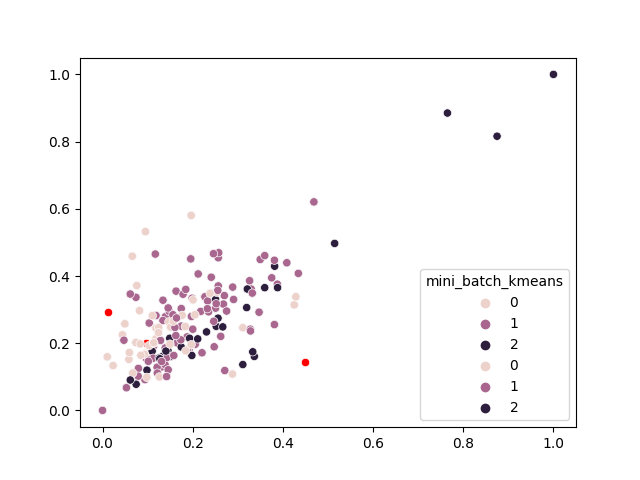

In [24]:
clusters = results["mini_batch_kmeans"]
sns.scatterplot(x=Xx, y=Xy, hue=clusters)
cursor = mplcursors.cursor(hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(df["country"][sel.target.index]))
plt.show()

In [25]:
clusters = results["spectralclustering"]
sns.scatterplot(x=Xx, y=Xy, hue=clusters)
cursor = mplcursors.cursor(hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(df["country"][sel.target.index]))
plt.show()

In [26]:
clusters = results["agglomerativeclustering"]
sns.scatterplot(x=Xx, y=Xy, hue=clusters)
cursor = mplcursors.cursor(hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(df["country"][sel.target.index]))
plt.show()